# SVM Classification on Rain in Australia Dataset Using PCA

This notebook performs classification to predict rain tomorrow using an SVM model.  
The dataset is preprocessed appropriately, dimensionality reduction is done via PCA (5 components),  
followed by training and evaluating an SVM model.  
Finally, decision boundaries are visualized on PCA components pairs.

## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## Step 2: Load Dataset  
The dataset is downsampled for computational efficiency.

In [2]:
df = pd.read_csv('weatherAUS.csv')[::10]

## Step 3: Data Preprocessing  
Handle missing values, encode categorical variables, and drop irrelevant columns.

In [3]:
df = df.dropna(subset=['RainTomorrow'])
df.drop('Date', axis=1, inplace=True, errors='ignore')

num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

for col in num_cols:
    df.fillna({col: df[col].median()}, inplace=True)

for col in cat_cols:
    df.fillna({col: df[col].mode()[0]}, inplace=True)

for col in cat_cols:
    if col not in ['RainTomorrow', 'RainToday']:
        df[col] = LabelEncoder().fit_transform(df[col])

df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

## Step 4: Feature and Target Separation

In [4]:
X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']

## Step 5: Split Dataset

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)

## Step 6: Feature Scaling

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Step 7: Dimensionality Reduction Using PCA  
PCA reduces the feature space to 5 principal components.

In [7]:
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

## Step 8: Train SVM Classifier

In [8]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_pca, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


## Step 9: Predictions on Test Set

In [9]:
y_pred = svm_model.predict(X_test_pca)

## Step 10: Model Evaluation  
Evaluate model performance using accuracy, confusion matrix, and classification report.

Model Accuracy: 0.82


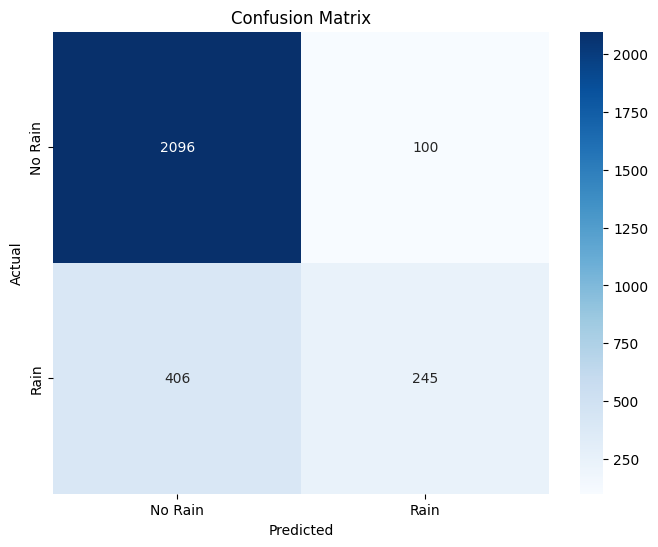

Classification Report:
              precision    recall  f1-score   support

     No Rain       0.84      0.95      0.89      2196
        Rain       0.71      0.38      0.49       651

    accuracy                           0.82      2847
   macro avg       0.77      0.67      0.69      2847
weighted avg       0.81      0.82      0.80      2847



In [10]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Rain', 'Rain']))

## Step 11: Decision Boundary Visualization  
The decision boundaries for the SVM classifier are visualized for pairs of PCA components.  
For clarity, we show plots for the first three principal components taken two at a time.

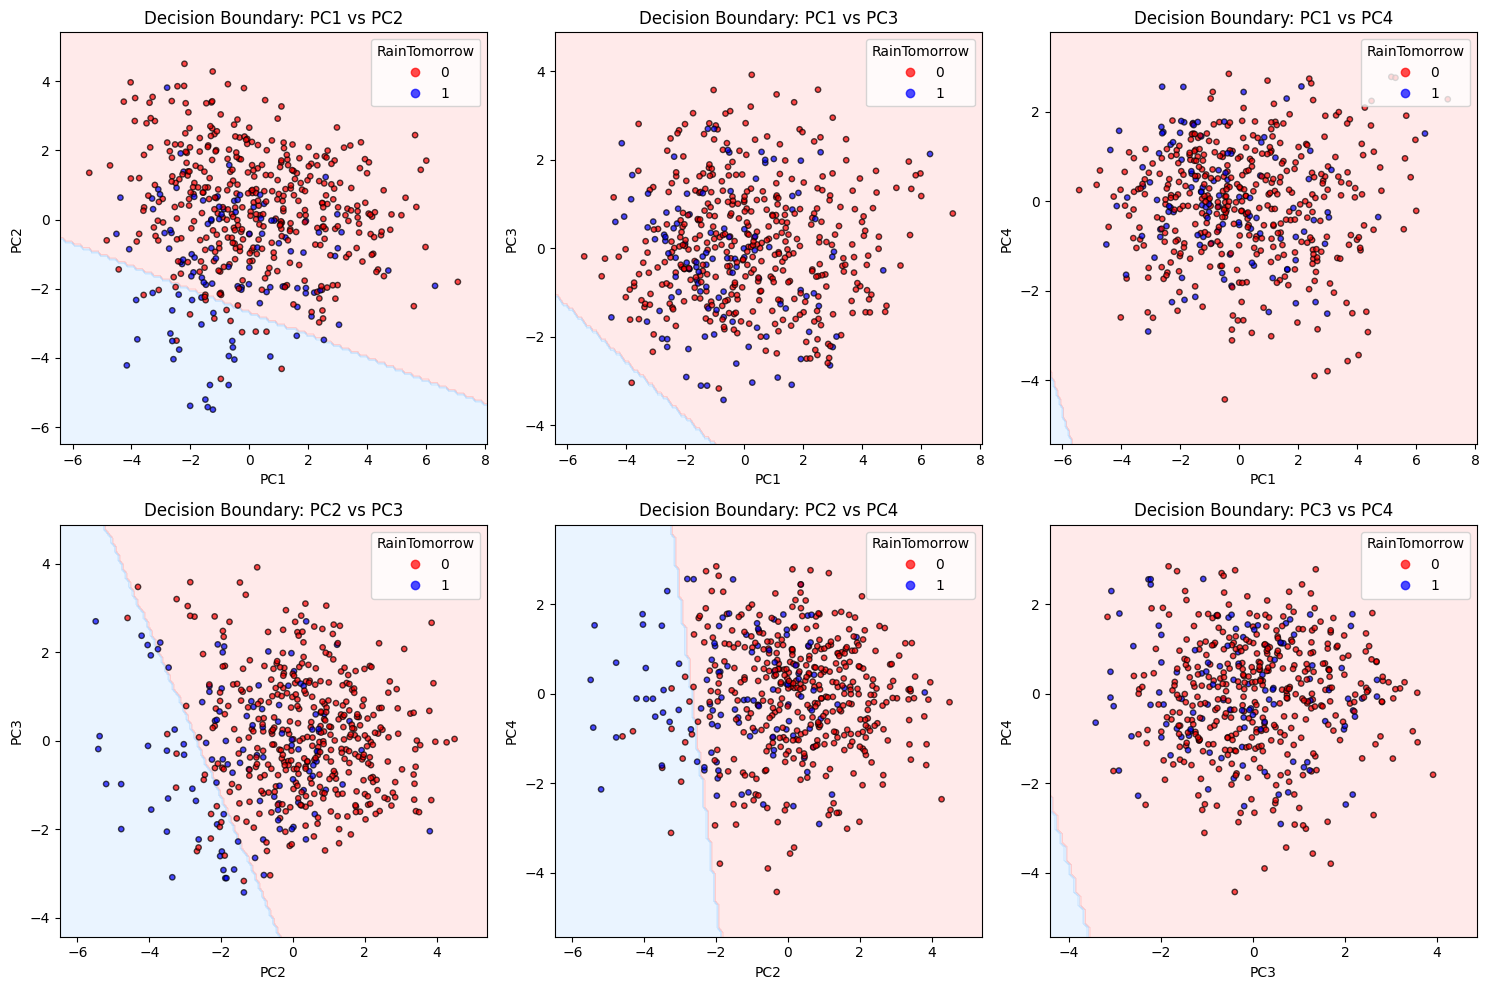

In [11]:
from itertools import combinations

max_points = 500
np.random.seed(42)
idx_sample = np.random.choice(len(X_test_pca), size=min(max_points, len(X_test_pca)), replace=False)
X_vis = X_test_pca[idx_sample]
y_vis = y_test.iloc[idx_sample].values

def plot_decision_boundary_2d(model, X, y, pc1, pc2):
    h = 0.1  # Mesh step size
    x_min, x_max = X[:, pc1].min() - 1, X[:, pc1].max() + 1
    y_min, y_max = X[:, pc2].min() - 1, X[:, pc2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Create temp array with all 5 PCA components, set others to 0
    X_full = np.zeros((grid_points.shape[0], 5))
    X_full[:, pc1] = grid_points[:, 0]
    X_full[:, pc2] = grid_points[:, 1]

    Z = model.predict(X_full).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.2, cmap=ListedColormap(['#FF9999','#99CCFF']))
    scatter = plt.scatter(X[:, pc1], X[:, pc2], c=y, cmap=ListedColormap(['red', 'blue']), s=15, edgecolor='k', alpha=0.7)
    plt.xlabel(f'PC{pc1+1}')
    plt.ylabel(f'PC{pc2+1}')
    plt.title(f'Decision Boundary: PC{pc1+1} vs PC{pc2+1}')
    plt.legend(*scatter.legend_elements(), title="RainTomorrow", loc='upper right')

pairs = list(combinations(range(4), 2))
plt.figure(figsize=(15, 10))
for i, (pc1, pc2) in enumerate(pairs):
    plt.subplot(2, 3, i + 1)
    plot_decision_boundary_2d(svm_model, X_vis, y_vis, pc1, pc2)
plt.tight_layout()
plt.show()

### Conclusion

This notebook provided a step-by-step guide to implementing an SVM classifier. We loaded the data, performed preprocessing, trained the model, and evaluated its performance. The results from the classification report show the precision, recall, and f1-score for each class, giving a comprehensive view of the model's effectiveness.